# Collaborative Filtering

In [ ]:
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
books=pd.read_csv('https://raw.githubusercontent.com/Reinalynn/Building-a-Book-Recommendation-System-using-Python/master/books10k.csv')
ratings=pd.read_csv('https://raw.githubusercontent.com/Reinalynn/Building-a-Book-Recommendation-System-using-Python/master/ratings10k.csv')

In [ ]:
books

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from th...,...,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m...,https://images.gr-assets.com/books/1279214118s...


In [ ]:
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
230589,5651,2822,4
230590,5737,2724,5
230591,3904,10,5
230592,3904,1791,3


In [ ]:
train, val = train_test_split(ratings, test_size=0.1,random_state=42)
#train, test = train_test_split(train, test_size=0.2, random_state=42)

dim_books=ratings.book_id.max()+1
dim_users=ratings.user_id.max()+1

In [ ]:
book_input = Input(shape=(1,), name="Book-Input")
book_embedding = Embedding(dim_books, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=(1,), name="User-Input")
user_embedding = Embedding(dim_users, 50, embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])

dense = Dense(1,activation='relu')(prod)

model = Model([user_input, book_input], dense)
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Book-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Book-Embedding (Embedding)     (None, 1, 50)        500050      ['Book-Input[0][0]']             
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        379150      ['User-Input[0][0]']             
                                                                                              

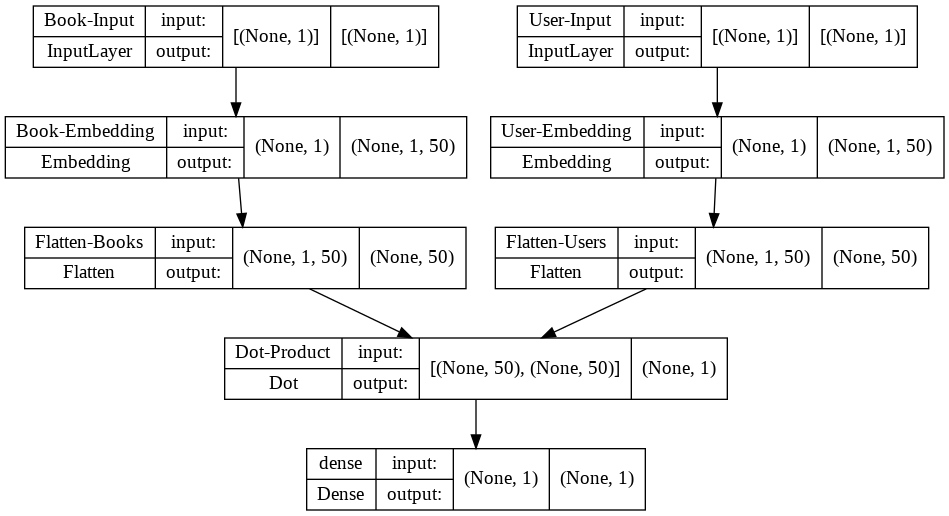

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#X_train=train[['book_id','user_id']].values
y_train=(train.rating - ratings.rating.min()) / (ratings.rating.max() - ratings.rating.min())
y_val=(val.rating - ratings.rating.min()) / (ratings.rating.max() - ratings.rating.min())

history = model.fit(x=[train.user_id.values,train.book_id.values], 
                    y=y_train.values, 
                    batch_size=64, 
                    epochs=10, 
                    verbose=1, 
                    validation_data=([val.user_id.values,val.book_id.values], y_val.values))

Epoch 1/10
3243/3243 [==============================] - 50s 15ms/step - loss: 0.0974 - val_loss: 0.0515
Epoch 2/10
3243/3243 [==============================] - 32s 10ms/step - loss: 0.0387 - val_loss: 0.0546
Epoch 3/10
3243/3243 [==============================] - 29s 9ms/step - loss: 0.0243 - val_loss: 0.0601
Epoch 4/10
3243/3243 [==============================] - 30s 9ms/step - loss: 0.0189 - val_loss: 0.0642
Epoch 5/10
3243/3243 [==============================] - 29s 9ms/step - loss: 0.0166 - val_loss: 0.0673
Epoch 6/10
3243/3243 [==============================] - 28s 9ms/step - loss: 0.0152 - val_loss: 0.0697
Epoch 7/10
3243/3243 [==============================] - 28s 9ms/step - loss: 0.0143 - val_loss: 0.0716
Epoch 8/10
3243/3243 [==============================] - 29s 9ms/step - loss: 0.0136 - val_loss: 0.0741
Epoch 9/10
3243/3243 [==============================] - 32s 10ms/step - loss: 0.0132 - val_loss: 0.0750
Epoch 10/10
3243/3243 [==============================] - 31s 9ms/step 

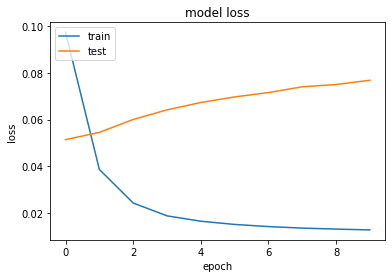

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
#Prediksi rekomendasi untuk user 1
import numpy as np
num_books= 100

book_list = books.book_id.sample(num_books).values
user_1 = np.array([1 for i in range(len(book_list))])

pred = model.predict([user_1,book_list]).reshape(num_books)

top_5_ids = (-pred).argsort()[:5]
top_5_books_id = book_list[top_5_ids]
top_5_books_rating = pred[top_5_ids]*(ratings.rating.max() - ratings.rating.min()) + ratings.rating.min()

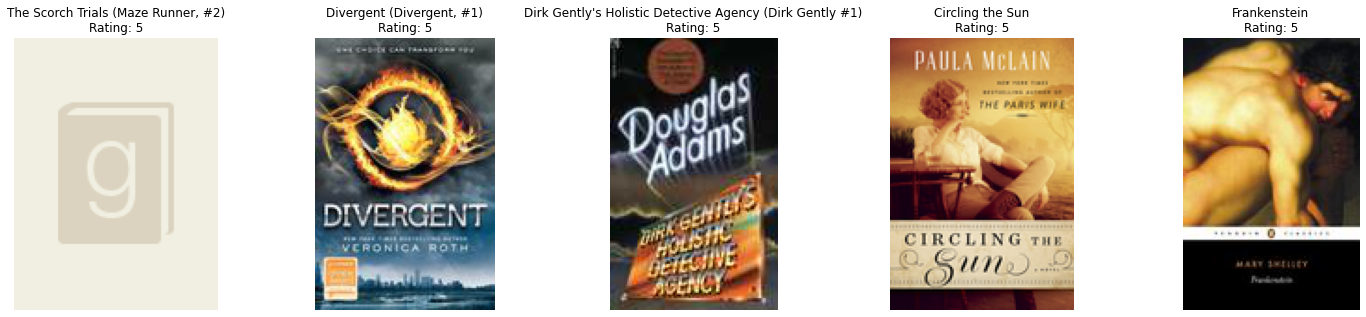

In [ ]:
from PIL import Image
import urllib
from IPython.display import display, HTML

display(HTML('<h2>Lima Buku yang Disukai oleh User 1:</h2>'))

liked_books_user_1 = ratings[ratings.user_id==1].sort_values('rating',ascending=False).book_id[:5].values
user_rating = ratings[ratings.user_id==1].sort_values('rating',ascending=False).rating[:5].values
fig1,ax1=plt.subplots(ncols=5,figsize=(25,5))
for i,id in enumerate(liked_books_user_1):
  a=Image.open(urllib.request.urlopen(books['image_url'].loc[id]))
  ax1[i].imshow(a)
  ax1[i].set_title('{}\nRating: {}'.format(books['title'].loc[id],user_rating[i]))
  ax1[i].axis('off')

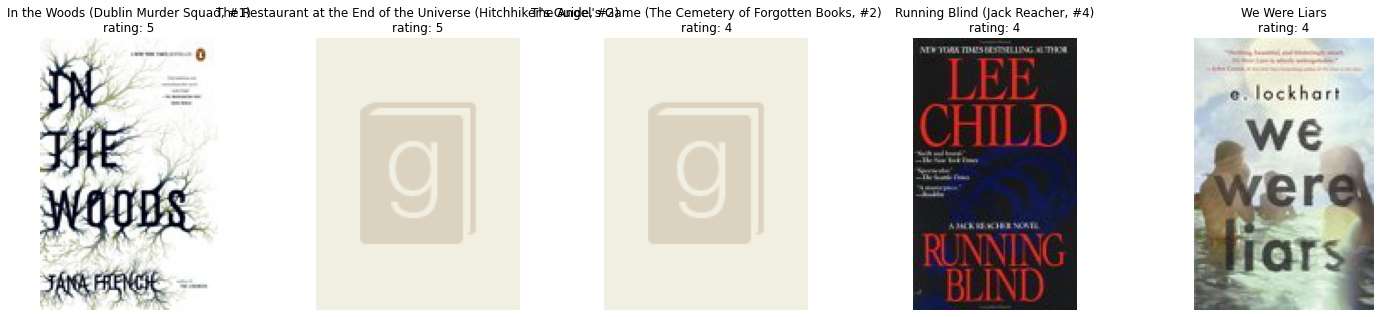

In [ ]:
display(HTML('<h2>Lima Buku yang Direkomendasikan ke User 1:</h2>'))
fig2,ax2=plt.subplots(ncols=5,figsize=(25,5))
for i,id in enumerate(top_5_books_id):
  a=Image.open(urllib.request.urlopen(books['image_url'].loc[id]))
  ax2[i].imshow(a)
  ax2[i].set_title('{}\nrating: {:.0f}'.format(books['title'].loc[id],top_5_books_rating[i]))
  ax2[i].axis('off')